# Imports and setting up viz

NB : conda env1 on PC, lam1env on spirit (Python3.12)

In [246]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
import sys
sys.path.append('../../python_tools/')
from tools import *
from tools_mapping import *
from tools_hf import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load files and edit datasets

LAM output analysis.

Simu irr et simu no-irr.

In [247]:
# lon_min=-10
# lon_max=4
# lat_min=34
# lat_max=46

In [248]:
hf_dir='../../../JZ_simu_outputs/LAM/HF_outputs'

## LMDZ

In [249]:
#noirr
filename = '{}/noirr/*_HF_histhf.nc'.format(hf_dir)

lmdz_noirr0 = xr.open_mfdataset(filename)
lmdz_noirr = lmdz_noirr0.rename({'time_counter':'time'})
lmdz_noirr = lmdz_noirr.assign_coords(time_decimal=lmdz_noirr.time.dt.hour + lmdz_noirr.time.dt.minute / 60)
lmdz_noirr.attrs['name'] = 'no_irr'
lmdz_noirr.attrs['plot_color']='red'
lmdz_noirr = lmdz_noirr.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

lmdz_noirr['sens']=-lmdz_noirr['sens']
lmdz_noirr['flat']=-lmdz_noirr['flat']

lmdz_noirr['ground_level'] = lmdz_noirr['phis'] / 9.81
lmdz_noirr['ground_level'].attrs['units'] = 'm'

lmdz_noirr

<xarray.Dataset>
Dimensions:               (lat: 35, lon: 49, presnivs: 79, time: 248,
                           axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 35.69 35.93 36.17 ... 43.38 43.62 43.87
  * lon                   (lon) float32 -9.899 -9.615 -9.33 ... 3.468 3.752
  * presnivs              (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
    time_centered         (time) datetime64[ns] dask.array<chunksize=(248,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2021-07-01T01:30:00 ... 2021-...
    time_instant          (time) datetime64[ns] dask.array<chunksize=(248,), meta=np.ndarray>
    time_decimal          (time) float64 1.5 4.5 7.5 10.5 ... 16.5 19.5 22.5
Dimensions without coordinates: axis_nbounds
Data variables: (12/51)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    phis                  (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    aire                  (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    contfracATM           (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    ...                    ...
    vitv                  (time, presnivs, lat, lon) float32 dask.array<chunksize=(248, 79, 35, 49), meta=np.ndarray>
    vitw                  (time, presnivs, lat, lon) float32 dask.array<chunksize=(248, 79, 35, 49), meta=np.ndarray>
    tke                   (time, presnivs, lat, lon) float32 dask.array<chunksize=(248, 79, 35, 49), meta=np.ndarray>
    geoph                 (time, presnivs, lat, lon) float32 dask.array<chunksize=(248, 79, 35, 49), meta=np.ndarray>
    ovap                  (time, presnivs, lat, lon) float32 dask.array<chunksize=(248, 79, 35, 49), meta=np.ndarray>
    ground_level          (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
Attributes:
    name:         no_irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Oct-31 04:51:22 GMT
    uuid:         126d911f-f6e4-4e38-9cec-e1f6463ce04d
    plot_color:   red

In [250]:
#no irr
filename = '{}/irr/*_HF_histhf.nc'.format(hf_dir)

lmdz_irr0 = xr.open_mfdataset(filename)
lmdz_irr =lmdz_irr0.rename({'time_counter':'time'})
lmdz_irr = lmdz_irr.assign_coords(time_decimal=lmdz_irr.time.dt.hour + lmdz_irr.time.dt.minute / 60)
lmdz_irr.attrs['name'] = 'irr'
lmdz_irr.attrs['plot_color']='#0C5DA5'
lmdz_irr = lmdz_irr.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

lmdz_irr['sens']=-lmdz_irr['sens']
lmdz_irr['flat']=-lmdz_irr['flat']

lmdz_irr['ground_level'] = lmdz_irr['phis'] / 9.81
lmdz_irr['ground_level'].attrs['units'] = 'm'

lmdz_irr

<xarray.Dataset>
Dimensions:               (lat: 35, lon: 49, presnivs: 79, time: 248,
                           axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 35.69 35.93 36.17 ... 43.38 43.62 43.87
  * lon                   (lon) float32 -9.899 -9.615 -9.33 ... 3.468 3.752
  * presnivs              (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
    time_centered         (time) datetime64[ns] dask.array<chunksize=(248,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2021-07-01T01:30:00 ... 2021-...
    time_instant          (time) datetime64[ns] dask.array<chunksize=(248,), meta=np.ndarray>
    time_decimal          (time) float64 1.5 4.5 7.5 10.5 ... 16.5 19.5 22.5
Dimensions without coordinates: axis_nbounds
Data variables: (12/51)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    phis                  (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    aire                  (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    contfracATM           (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    ...                    ...
    vitv                  (time, presnivs, lat, lon) float32 dask.array<chunksize=(248, 79, 35, 49), meta=np.ndarray>
    vitw                  (time, presnivs, lat, lon) float32 dask.array<chunksize=(248, 79, 35, 49), meta=np.ndarray>
    tke                   (time, presnivs, lat, lon) float32 dask.array<chunksize=(248, 79, 35, 49), meta=np.ndarray>
    geoph                 (time, presnivs, lat, lon) float32 dask.array<chunksize=(248, 79, 35, 49), meta=np.ndarray>
    ovap                  (time, presnivs, lat, lon) float32 dask.array<chunksize=(248, 79, 35, 49), meta=np.ndarray>
    ground_level          (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
Attributes:
    name:         irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Oct-31 05:16:38 GMT
    uuid:         f5df34c4-d004-4324-87e7-258a451aed33
    plot_color:   #0C5DA5

## ORCHIDEE

In [251]:
filename = '{}/noirr/*HF_sechiba_out_2.nc'.format(hf_dir)

orc_noirr0 = xr.open_mfdataset(filename)
orc_noirr = orc_noirr0.rename({'time_counter':'time'})
orc_noirr = orc_noirr.assign_coords(time_decimal=orc_noirr.time.dt.hour + orc_noirr.time.dt.minute / 60)
orc_noirr.attrs['name'] = 'no_irr'
orc_noirr.attrs['plot_color']='red'
orc_noirr = orc_noirr.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

orc_noirr

<xarray.Dataset>
Dimensions:               (lat: 35, lon: 49, veget: 15, time: 248,
                           axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 35.69 35.93 36.17 ... 43.38 43.62 43.87
  * lon                   (lon) float32 -9.899 -9.615 -9.33 ... 3.468 3.752
  * veget                 (veget) float32 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
    time_centered         (time) datetime64[ns] dask.array<chunksize=(248,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2021-07-01T01:30:00 ... 2021-...
    time_decimal          (time) float64 1.5 4.5 7.5 10.5 ... 16.5 19.5 22.5
Dimensions without coordinates: axis_nbounds
Data variables: (12/24)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    Areas                 (lat, lon) float32 dask.array<chunksize=(35, 49), meta=np.ndarray>
    Contfrac              (lat, lon) float32 dask.array<chunksize=(35, 49), meta=np.ndarray>
    swnet                 (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    lwnet                 (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    ...                    ...
    tair                  (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    qair                  (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    humrel                (time, veget, lat, lon) float32 dask.array<chunksize=(248, 15, 35, 49), meta=np.ndarray>
    root_deficit          (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    netirrig              (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    irrigation            (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
Attributes:
    name:         no_irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Oct-31 04:51:17 GMT
    uuid:         25ce2944-15fd-402f-bfed-3024fefce536
    plot_color:   red

In [252]:
filename = '{}/irr/*HF_sechiba_out_2.nc'.format(hf_dir)

orc_irr0 = xr.open_mfdataset(filename)
orc_irr = orc_irr0.rename({'time_counter':'time'})
orc_irr = orc_irr.assign_coords(time_decimal=orc_irr.time.dt.hour + orc_irr.time.dt.minute / 60)
orc_irr.attrs['name'] = 'irr'
orc_irr.attrs['plot_color']='#0C5DA5'
orc_irr = orc_irr.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

orc_irr

<xarray.Dataset>
Dimensions:               (lat: 35, lon: 49, veget: 15, time: 248,
                           axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 35.69 35.93 36.17 ... 43.38 43.62 43.87
  * lon                   (lon) float32 -9.899 -9.615 -9.33 ... 3.468 3.752
  * veget                 (veget) float32 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
    time_centered         (time) datetime64[ns] dask.array<chunksize=(248,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2021-07-01T01:30:00 ... 2021-...
    time_decimal          (time) float64 1.5 4.5 7.5 10.5 ... 16.5 19.5 22.5
Dimensions without coordinates: axis_nbounds
Data variables: (12/24)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    Areas                 (lat, lon) float32 dask.array<chunksize=(35, 49), meta=np.ndarray>
    Contfrac              (lat, lon) float32 dask.array<chunksize=(35, 49), meta=np.ndarray>
    swnet                 (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    lwnet                 (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    ...                    ...
    tair                  (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    qair                  (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    humrel                (time, veget, lat, lon) float32 dask.array<chunksize=(248, 15, 35, 49), meta=np.ndarray>
    root_deficit          (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    netirrig              (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
    irrigation            (time, lat, lon) float32 dask.array<chunksize=(248, 35, 49), meta=np.ndarray>
Attributes:
    name:         irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Oct-31 05:16:33 GMT
    uuid:         9f3b5cbf-cc6c-4c1c-ab94-98404e8b374c
    plot_color:   #0C5DA5

## Masking

### IP continental subdomain

In [253]:
# Define masks
 
con_mask_2D_ORC= orc_noirr.mean(dim='time')['Contfrac']>0.95
con_mask_2D_ORC.attrs['name']='Continental mask (95%)'

ip_polygon_mask_2D=polygon_to_mask(orc_noirr.mean(dim="time"), iberian_peninsula)
ip_polygon_mask_2D.attrs['name']='Iberian Peninsula polygon mask'

#combine two masks
ip_mask = con_mask_2D_ORC * ip_polygon_mask_2D
ip_mask.attrs['name']='IPmask'

In [254]:
#ORC
ip_orc_noirr = apply_2Dmask_to_dataset(orc_noirr, ip_mask, dsname='no_irr')
ip_orc_irr = apply_2Dmask_to_dataset(orc_irr, ip_mask, dsname='irr')

In [255]:
#LMDZ
ip_lmdz_noirr = apply_2Dmask_to_dataset(lmdz_noirr, ip_mask, dsname='no_irr')
ip_lmdz_irr = apply_2Dmask_to_dataset(lmdz_irr, ip_mask, dsname='irr')

## high_irr vs low_irr

In [256]:
#on grid cell
#highirr
Cendrosa_lon=0.6
Cendrosa_lat=41.7
#lowirr
ElsPlans_lon=1.1
ElsPlans_lat=41.5

In [257]:
cen_lmdz_noirr = lmdz_noirr.sel(lon=Cendrosa_lon,lat=Cendrosa_lat,method='nearest').copy()
cen_lmdz_noirr.attrs['name']='La Cendrosa no_irr'
cen_lmdz_irr = lmdz_irr.sel(lon=Cendrosa_lon,lat=Cendrosa_lat,method='nearest').copy()
cen_lmdz_irr.attrs['name']='La Cendrosa irr'
cen_orc_noirr = orc_noirr.sel(lon=Cendrosa_lon,lat=Cendrosa_lat,method='nearest').copy()
cen_orc_noirr.attrs['name']='La Cendrosa no_irr'
cen_orc_irr = orc_irr.sel(lon=Cendrosa_lon,lat=Cendrosa_lat,method='nearest').copy()
cen_orc_irr.attrs['name']='La Cendrosa irr'

In [258]:
els_lmdz_noirr = lmdz_noirr.sel(lon=ElsPlans_lon,lat=ElsPlans_lat,method='nearest').copy()
els_lmdz_noirr.attrs['name']='Els Plans no_irr'
els_lmdz_irr = lmdz_irr.sel(lon=ElsPlans_lon,lat=ElsPlans_lat,method='nearest').copy()
els_lmdz_irr.attrs['name']='Els Plans irr'
els_orc_noirr = orc_noirr.sel(lon=ElsPlans_lon,lat=ElsPlans_lat,method='nearest').copy()
els_orc_noirr.attrs['name']='Els Plans no_irr'
els_orc_irr = orc_irr.sel(lon=ElsPlans_lon,lat=ElsPlans_lat,method='nearest').copy()
els_orc_irr.attrs['name']='Els Plans irr'

In [259]:
cendrosa_gl= cen_lmdz_noirr['ground_level'].mean(dim='time').values.item()
elsplans_gl= els_lmdz_noirr['ground_level'].mean(dim='time').values.item()
cendrosa_gl,  elsplans_gl

(315.8647155761719, 474.1612548828125)

# Maps

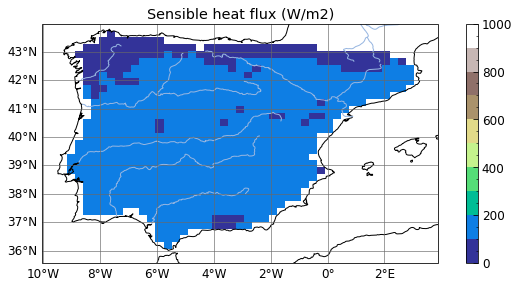

In [260]:
var='sens'
ds=ip_lmdz_irr

vmin=0
vmax=1000
# vmin,vmax = None, None
cmap=myterrain
# title='off'
title=None
# title='Evaporative fraction (irr, JJA)'
# clabel='Irrigation (mm/d)'
clabel=None
map_ave(ds, var, vmin=vmin, vmax=vmax, cmap=cmap,
        title=title, clabel=clabel)

No significance mask applied


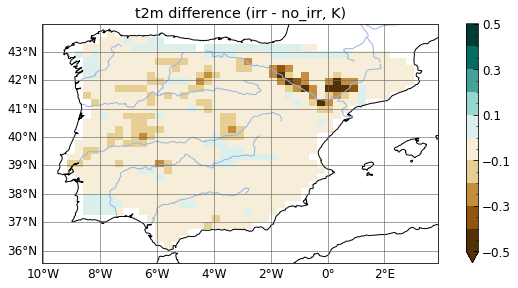

In [261]:
#Diff map
var='t2m'
ds1=ip_lmdz_irr
ds2=ip_lmdz_noirr

vmax= 0.5
vmin=-0.5
# vmin,vmax = None, None
cmap=emb_neutral
title=None
map_diff_ave(ds1, ds2, var, vmin=vmin, vmax=vmax, cmap=cmap, 
             sig=False,
             title=title, clabel=clabel)

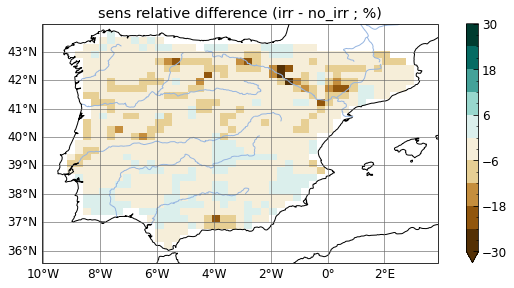

In [262]:
#Relative diff map
var='sens'
ds1=ip_lmdz_irr
ds2=ip_lmdz_noirr
maxvalue= 30
minvalue=-30
# minvalue, maxvalue = None, None

cmap=emb_neutral

map_rel_diff_ave(ds1, ds2, var, cmap=cmap, vmin=minvalue, vmax=maxvalue)

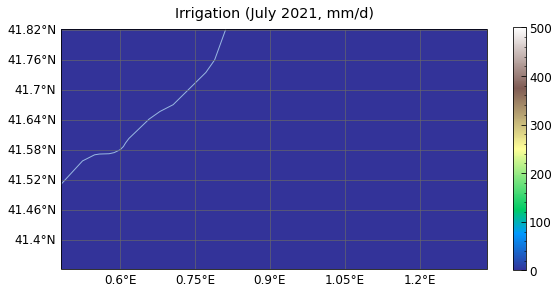

In [263]:
#Display map of var for ds on restricted area
var='irrigation'
ds = ip_orc_irr
# ds = std
latmin=41.35
latmax=41.9
lonmin=0.6
lonmax=1.4
cmap='terrain'
vmin=0
vmax=500
title='Irrigation (July 2021, mm/d)'

#restrict ds to latmin, latmax, lonmin, lonmax
ds = ds.where(ds.lat >= latmin, drop=True).where(ds.lat <= latmax, drop=True)
ds = ds.where(ds.lon >= lonmin, drop=True).where(ds.lon <= lonmax, drop=True)
plotvar = ds[var].mean(dim='time')

map_plotvar(plotvar, cmap=cmap, vmin=vmin,vmax=vmax, title=title)

# Time series and diurnal cycle

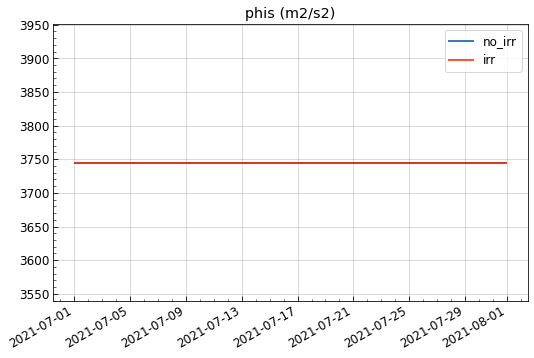

In [264]:
var='phis'

ds1=lmdz_noirr
ds2=lmdz_irr
ds_list=[ds1, ds2]#, ds3]
# ds_list=[ds1]

title=None
time_series_ave(ds_list, var, title='{} ({})'.format(var, ds1[var].attrs['units']))


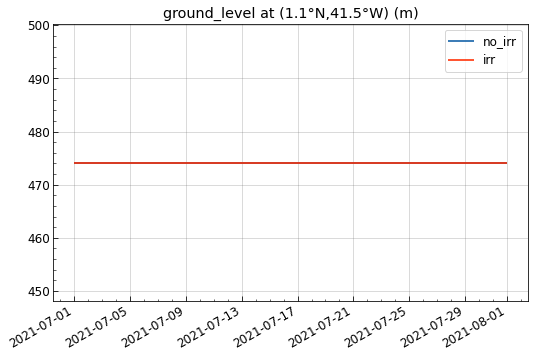

In [265]:
#en un point precis
lon=Cendrosa_lon
lat=Cendrosa_lat

lon=ElsPlans_lon
lat=ElsPlans_lat
# lon=-2
# lat=41
var='ground_level'
ds1=lmdz_noirr
ds2=lmdz_irr
# ds1=orc_noirr
# ds2=orc_irr
ds_list=[ds1, ds2]
time_series_lonlat(ds_list, var, lon, lat)

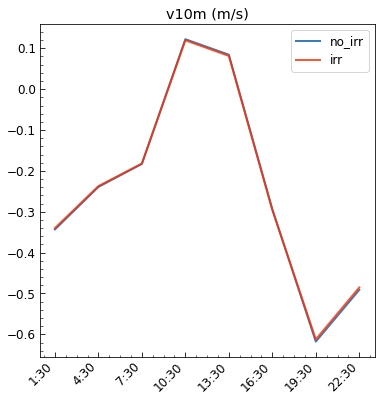

In [266]:
var='v10m'

ds1=ip_lmdz_noirr
ds2=ip_lmdz_irr
# ds1=ip_orc_noirr
# ds2=ip_orc_irr
ds_list=[ds1, ds2]#, ds3]
# ds_list=[ds2]

title=None
diurnal_cycle_ave(ds_list, var, title='{} ({})'.format(var, ds1[var].attrs['units']))

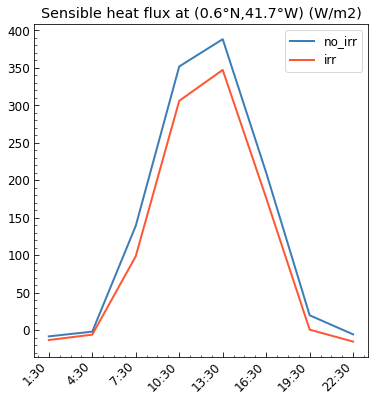

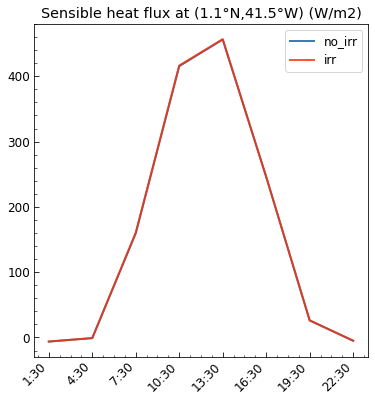

In [267]:
var='sens'

ds1=ip_lmdz_noirr
ds2=ip_lmdz_irr
# ds1=ip_orc_noirr
# ds2=ip_orc_irr

ds_list=[ds1, ds2]#, ds3]
# ds_list=[ds2]

title=None

lon=Cendrosa_lon
lat=Cendrosa_lat

diurnal_cycle_lonlat(ds_list, var, lon=lon, lat=lat)

lon=ElsPlans_lon
lat=ElsPlans_lat

diurnal_cycle_lonlat(ds_list, var, lon=lon, lat=lat)

# Vertical profiles

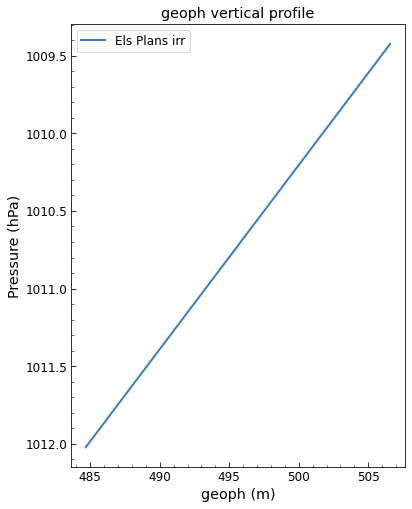

In [268]:
var='geoph'
ds1=els_lmdz_irr
ds2=els_lmdz_noirr
ds3=cen_lmdz_irr
ds4=cen_lmdz_noirr

# ds_list=[ds1, ds2, ds3, ds4]
ds_list=[ds1]

preslevelmax=2

title=None

profile_preslevs_local(ds_list, var, title=title, preslevelmax=preslevelmax)

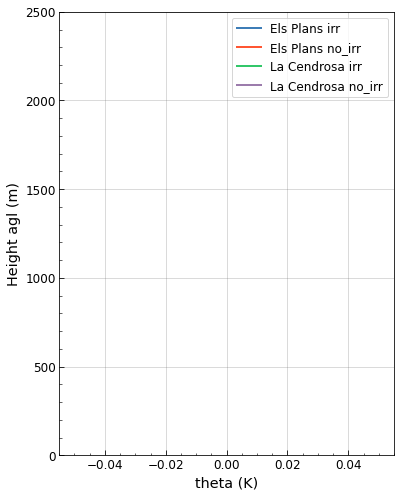

In [270]:
var='theta'
ds1=els_lmdz_irr
ds2=els_lmdz_noirr
ds3=cen_lmdz_irr
ds4=cen_lmdz_noirr

day='2017-07-10'

ds11=filter_xarray_by_day(ds1, day)
ds21=filter_xarray_by_day(ds2, day)
ds31=filter_xarray_by_day(ds3, day)
ds41=filter_xarray_by_day(ds4, day)

ds_list=[ds1, ds2, ds3, ds4]
ds_list=[ds11, ds21, ds31, ds41]

altmax=2500

title=None

# profile_preslevs_local(ds_list, var, title=title, preslevelmax=preslevelmax)
profile_altitude_local_mean(ds_list, var, title=title, altmax=altmax,
                       nbins=None,
                       substract_gl=False,
                       )

In [271]:
ds11

<xarray.Dataset>
Dimensions:               (presnivs: 79, time: 0, axis_nbounds: 2)
Coordinates:
    lat                   float32 41.46
    lon                   float32 1.193
  * presnivs              (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
    time_centered         (time) datetime64[ns] dask.array<chunksize=(0,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 
    time_instant          (time) datetime64[ns] dask.array<chunksize=(0,), meta=np.ndarray>
    time_decimal          (time) float64 
Dimensions without coordinates: axis_nbounds
Data variables: (12/51)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(0, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(0, 2), meta=np.ndarray>
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(0, 2), meta=np.ndarray>
    phis                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    aire                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    contfracATM           (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    ...                    ...
    vitv                  (time, presnivs) float32 dask.array<chunksize=(0, 79), meta=np.ndarray>
    vitw                  (time, presnivs) float32 dask.array<chunksize=(0, 79), meta=np.ndarray>
    tke                   (time, presnivs) float32 dask.array<chunksize=(0, 79), meta=np.ndarray>
    geoph                 (time, presnivs) float32 dask.array<chunksize=(0, 79), meta=np.ndarray>
    ovap                  (time, presnivs) float32 dask.array<chunksize=(0, 79), meta=np.ndarray>
    ground_level          (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
Attributes:
    name:         Els Plans irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Oct-31 05:16:38 GMT
    uuid:         f5df34c4-d004-4324-87e7-258a451aed33
    plot_color:   #0C5DA5

In [151]:
def profile_altitude_multipletimes(ds_list, var, times, altmin=0, altmax=2000):
    n_ax = len(times)
    fig, axs = plt.subplots(1, n_ax, figsize=(5*n_ax, 6))
    # Flatten axs only if it's an array (i.e., more than one subplot)
    axes = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    for i, time in enumerate(times):
        hour=times_correspondance[time]
        title = f"{var} at {hour}"
        
        # Filter datasets by the specified time and plot
        ds_list_tmp = [ds.where(ds['time_decimal']==time) for ds in ds_list]
        profile_altitude_local_mean(ds_list_tmp,
                                    var,
                                    ax=axes[i],
                                    title=title,
                                    altmin=altmin,
                                    altmax=altmax
        )

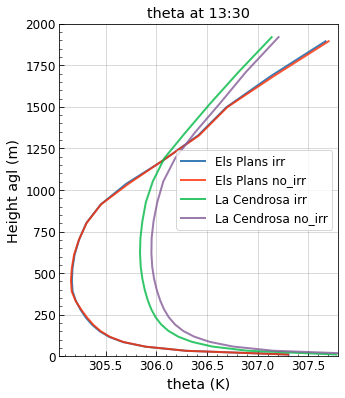

In [156]:
var='theta'
ds1=els_lmdz_irr
ds2=els_lmdz_noirr
ds3=cen_lmdz_irr
ds4=cen_lmdz_noirr

ds_list=[ds1, ds2, ds3, ds4]

altmin=-0
altmax=2000

times=[1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 22.5]
times=[13.5, 16.5]
times=[13.5]

profile_altitude_multipletimes(ds_list, var, times, altmin=altmin, altmax=altmax)